In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

path_to_this_notebook = os.path.abspath('.')
path_to_project = path_to_this_notebook[:path_to_this_notebook.find('note')]
sys.path.append(path_to_project)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from src.td3_code.agents.td3 import TD3Agent
from src.td3_code.memory.trajectory_replay_buffer import TrajectoryMemoryBuffer
from src.td3_code.memory.transition_replay_buffer import TransitionMemoryBuffer
from src.td3_code.runners.runner import Runner

from src.samplers.load_samplers import load_samplers
from src.environments.create_env import create_env

In [18]:
import numpy as np 
import gym

import ray
from ray.tune import register_env

# create and initialize the environment
# env = gym.make("Pendulum-v1")

### Plotting

In [19]:
def plot_results(env, results_list, figsize=(12, 7)):
    plt.figure(figsize=figsize)
    plt.subplot(121)
    i_violations = [res['i_constraints_violation'] for res in results_list]
    p_violations = [res['power_flow_constraints_violation'] for res in results_list]
    plt.plot(env.timesteps_str[:-1], i_violations, label='i_violation')
    plt.plot(env.timesteps_str[:-1], p_violations, label='p_violation')
    _ = plt.xticks(env.timesteps_str[::6])
    _ = plt.legend()
    _ = plt.title('Constraint violations')

    plt.subplot(122)
    rewards = [res['reward'] for res in results_list]
    feeders_price = [res['feeders_power_price'] for res in results_list]
    pvs_price = [res['pvs_power_price'] for res in results_list]
    evs_welfare = [res['evs_social_welfare'] for res in results_list]

    plt.plot(env.timesteps_str[:-1], rewards, label='total reward')
    plt.plot(env.timesteps_str[:-1], feeders_price, label='feeders price')
    plt.plot(env.timesteps_str[:-1], pvs_price, label='PVs price')
    plt.plot(env.timesteps_str[:-1], evs_welfare, label='EVs welfare')
    _ = plt.xticks(env.timesteps_str[::6])
    _ = plt.legend()
    _ = plt.title('Objective')

### Environment stuff

In [20]:
config = {'path_to_data': './data/', 
          't0_hr': 6., # When the episode start (default value 6AM)
          'dt_min': 30, # Timestep size
          'ev_dt_min': 60, # Timestep size for EV arrivals
          'ev_sampling_dt_min': 60,  # How EV sessions are sampled from the data
          'apply_gaussian_noise': False, # Make data noisy
          'ev_utility_coef_mean': 1, # Mean value of the utility coefficient for the EVs
          'ev_utility_coef_scale': 0.13, # STD of the utility coefficient for the EVs
          'days_per_month_train': 20, # Days per month for training 
          'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11',],
           # Months to sample EV sessions for training 
          'grid_to_use': 'ieee16', # What grid topology to use. Now supports only IEEE16. 
          'ev_session_months_test': ['05', '12'], # Months to sample EV sessions for test 
          'n_ps_pvs': 4, # Amount of solar panels that use PecanStreet data
          'n_canopy_pvs': 0, # Amount of solar panels that use canopy data
          'canopy_pv_rated_power': 250, # Rated power of these panels
          'n_loads': 0, # Amount of inflexible loads
          'n_feeders': 1, # Amount of feeders
          'n_ev_chargers': 4, # Amount of EV chargers
          
          'ps_pvs_rated_power': 4, # Rated power of these panels
          'avg_evs_per_day': 3.5, # Scaling of the EV arrival rate
          'feeder_p_min': -5, # Capacity of the feeders
          'g': 4, # Conductance of each line
          'i_max': 25, # Capacity of each line
          # new and improved cool config options
          'environment_type': 'gym', # normal / gym
          'use_constraint_projection': False,
          'normalize_environment_outputs': True,
          'epochs': 15,
          }

In [21]:
# Preload samplers, it is necessary to avoid re-loading data each time env is created
(ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
 price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

{'path_to_data': './data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'gym', 'use_constraint_projection': False, 'normalize_environment_outputs': True, 'epochs': 15}


In [22]:
def env_creator(a):
    (ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
     price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

    return create_env(
        config,
        ps_samplers_dict,
        ps_metadata,
        canopy_sampler,
        canopy_metadata,
        price_sampler,
        price_metadata,
        ev_sampler,
        elaadnl_metadata
    )
register_env("my_env", env_creator)

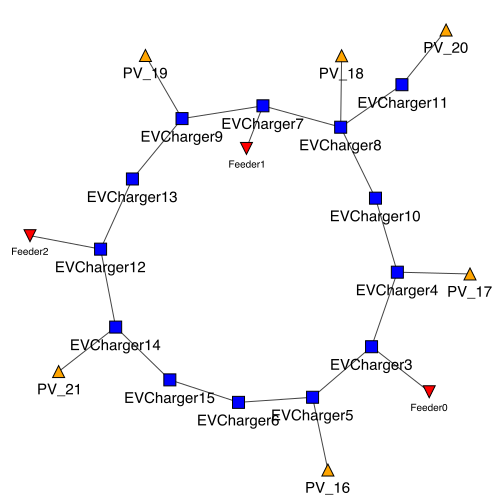

In [23]:
# Create environment
env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)
env.plot_grid(bbox=(0, 0, 500, 500))

In [24]:
env.action_space, env.observation_space

(Box([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], (44,), float32),
 Box([ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1.], [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 

In [25]:
observation_dim = env.observation_space.shape[0]
action_dim =  env.action_space.shape[0]
max_action_value = env.action_space.high[0]
scheme = {'observations': env.observation_space.shape, 
          'observations_next': env.observation_space.shape,
          'actions': env.action_space.shape,
          'done': (1, ), 'reward': (1, ), 'reset_mask': (1, )}

### Normal transitions

In [32]:
memory_trans = TransitionMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=2000, 
                                      sample_during_episode=True)


memory_traj = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                     use_transitions=False, sample_during_episode=False)

memory_traj_trans = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                          use_transitions=True, sample_during_episode=True)



lstm_dims_list = [2]
hidden_dims_list = [64, 64]

agent = TD3Agent(observation_dim, action_dim, 1, lstm_dims_list, hidden_dims_list,
                 actor_lr=8e-4, critic_lr=8e-4,  discount=0.99, tau=0.005,
                 policy_noise=0.2, noise_clip=0.5, policy_update_freq=2)
runner = Runner(env, memory_trans, agent)

batch_size = 16

USING DEVICE cpu


In [15]:
n_eps = 101
print_each = 50
test_each = 50
n_test_episodes = 10

keys_to_print = ['reward']
train_results = defaultdict(list)
test_results = defaultdict(list)

for ep in range(1, n_eps):
    #print('            EP%d' % ep)
    episode_results = runner.run(train=True, save_to_memory=True, train_bath_size=batch_size)
    for key, val in episode_results.items():
        train_results[key].append(val)
    
    if ep % print_each == 0:
        print('Training episode %d    ' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))
        print()
        
    if ep % test_each == 0:
        current_test_results = defaultdict(list)
        for test_ep in range(n_test_episodes):
            episode_results = runner.run(train=False, save_to_memory=False)
            for key, val in episode_results.items():
                current_test_results[key].append(val)
        current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}
        for key, val in current_test_results.items():
            test_results[key].append(val)
            
        print('Test run after episode %d:' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, current_test_results[key]))
        print()
        

    model.name="unknown";
      - termination condition: maxIterations
      - message from solver: Ipopt 3.11.1\x3a Maximum Number of Iterations
        Exceeded.


KeyboardInterrupt: 

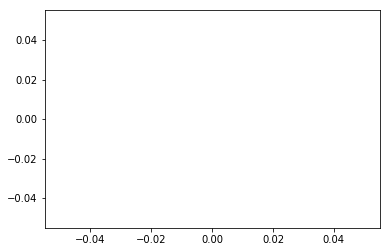

In [ ]:
plt.plot(train_results['reward'])

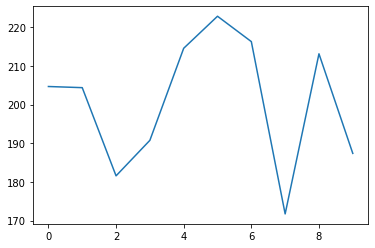

In [ ]:
plt.plot(test_results['reward'])

### Transitions from the Traj buffer
**seemed most promising in file Grigs_td3**

In [33]:
memory_trans = TransitionMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=2000, 
                                      sample_during_episode=True)


memory_traj = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                     use_transitions=False, sample_during_episode=False)

memory_traj_trans = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                          use_transitions=True, sample_during_episode=True)



lstm_dims_list = [2]
hidden_dims_list = [64, 64]

agent = TD3Agent(observation_dim, action_dim, 1, lstm_dims_list, hidden_dims_list,
                 actor_lr=8e-4, critic_lr=8e-4,  discount=0.99, tau=0.005,
                 policy_noise=0.2, noise_clip=0.5, policy_update_freq=2)

runner = Runner(env, memory_traj_trans, agent)

batch_size = 16

In [ ]:
n_eps = 1001
print_each = 50
test_each = 50
n_test_episodes = 10

keys_to_print = ['reward']
train_results = defaultdict(list)
test_results = defaultdict(list)

for ep in range(1, n_eps):
    #print('            EP%d' % ep)
    episode_results = runner.run(train=True, save_to_memory=True, train_bath_size=batch_size)
    for key, val in episode_results.items():
        train_results[key].append(val)
    
    if ep % print_each == 0:
        print('Training episode %d    ' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))
        print()
        
    if ep % test_each == 0:
        current_test_results = defaultdict(list)
        for test_ep in range(n_test_episodes):
            episode_results = runner.run(train=False, save_to_memory=False)
            for key, val in episode_results.items():
                current_test_results[key].append(val)
        current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}
        for key, val in current_test_results.items():
            test_results[key].append(val)
            
        print('Test run after episode %d:' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, current_test_results[key]))
        print()
        

In [ ]:
plt.plot(test_results['reward'])

###  Transitions from the Traj buffer, learning after episode

In [ ]:
memory_trans = TransitionMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=2000, 
                                      sample_during_episode=True)


memory_traj = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                     use_transitions=False, sample_during_episode=False)

memory_traj_trans = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                          use_transitions=True, sample_during_episode=False)



lstm_dims_list = []
hidden_dims_list = [64, 64]

agent = TD3Agent(observation_dim, action_dim, max_action_value, lstm_dims_list, hidden_dims_list,
                 actor_lr=8e-4, critic_lr=8e-4,  discount=0.99, tau=0.05,
                 policy_noise=0.2, noise_clip=0.5, policy_update_freq=2)

runner = Runner(env, memory_traj_trans, agent)

batch_size =  512

In [ ]:
n_eps = 50401
print_each = 50
test_each = 50
n_test_episodes = 10

keys_to_print = ['reward']
train_results = defaultdict(list)
test_results = defaultdict(list)

for ep in range(1, n_eps):
    #print('            EP%d' % ep)
    episode_results = runner.run(train=True, save_to_memory=True, train_bath_size=batch_size)
    for key, val in episode_results.items():
        train_results[key].append(val)
    
    if ep % print_each == 0:
        print('Training episode %d    ' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))
        print()
        
    if ep % test_each == 0:
        current_test_results = defaultdict(list)
        for test_ep in range(n_test_episodes):
            episode_results = runner.run(train=False, save_to_memory=False)
            for key, val in episode_results.items():
                current_test_results[key].append(val)
        current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}
        for key, val in current_test_results.items():
            test_results[key].append(val)
            
        print('Test run after episode %d:' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, current_test_results[key]))
        print()
        

In [ ]:
plt.plot(train_results['reward'])

###  Trajectories from the Traj buffer, learning after episode

In [ ]:
memory_trans = TransitionMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=2000, 
                                      sample_during_episode=True)


memory_traj = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                     use_transitions=False, sample_during_episode=True)

memory_traj_trans = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                          use_transitions=True, sample_during_episode=False)



lstm_dims_list = [64]
hidden_dims_list = [64]

agent = TD3Agent(observation_dim, action_dim, max_action_value, lstm_dims_list, hidden_dims_list,
                 actor_lr=8e-4, critic_lr=8e-4,  discount=0.99, tau=0.05,
                 policy_noise=0.2, noise_clip=0.5, policy_update_freq=2)

runner = Runner(env, memory_traj, agent)

batch_size =  1

In [ ]:
n_eps = 51
print_each = 10
test_each = 10
n_test_episodes = 10

keys_to_print = ['reward']
train_results = defaultdict(list)
test_results = defaultdict(list)

for ep in range(1, n_eps):
    #print('            EP%d' % ep)
    episode_results = runner.run(train=True, save_to_memory=True, train_bath_size=batch_size)
    for key, val in episode_results.items():
        train_results[key].append(val)
    
    if ep % print_each == 0:
        print('Training episode %d    ' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))
        print()
        
    if ep % test_each == 0:
        current_test_results = defaultdict(list)
        for test_ep in range(n_test_episodes):
            episode_results = runner.run(train=False, save_to_memory=False)
            for key, val in episode_results.items():
                current_test_results[key].append(val)
        current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}
        for key, val in current_test_results.items():
            test_results[key].append(val)
            
        print('Test run after episode %d:' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, current_test_results[key]))
        print()
        

AssertionError: Device Feeder0 received p which is out of bounds: 0.84

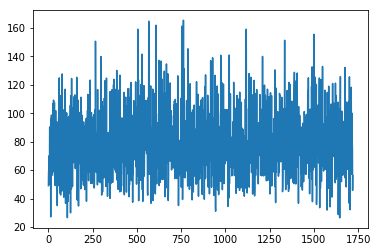

In [ ]:
plt.plot(train_results['reward'])

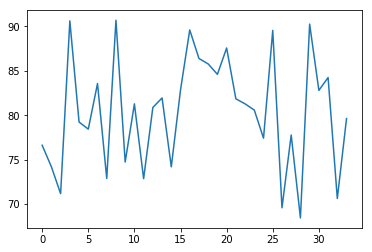

In [ ]:
plt.plot(test_results['reward'])

Reward = 84.92


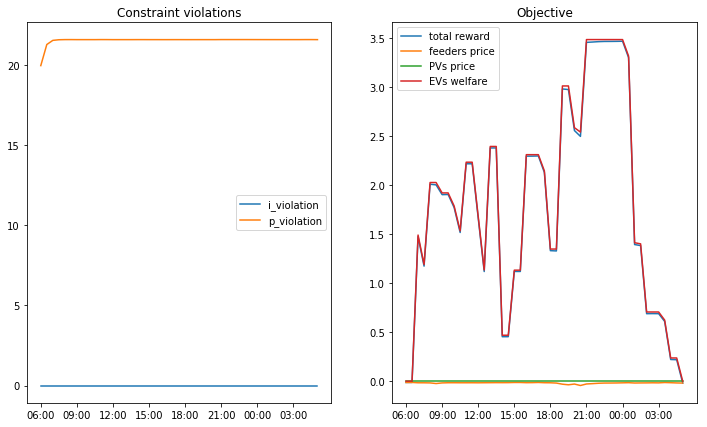

In [ ]:
episode_results, final_results_list = runner.run(train=False, save_to_memory=False, final=True)

print('Reward = %.2f' % episode_results['reward'])
plot_results(env, final_results_list, figsize=(12, 7))